In [1]:
import pandas as pd
import pymongo
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import math
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from datetime import timedelta
%matplotlib inline

ModuleNotFoundError: No module named 'tqdm'

In [2]:
db = pymongo.MongoClient().data

# DATA

The data is obtained from Dinero Payment Services Pvt. Ltd. which operate a payment gateway aggregation service in India. The `PAY_ID` field in the data refers to the unique ID of each merchant/business that is using the services offered by the company on their platform. The `STATUS` field is used to track the status of the payment requests where "Captured" means that the payment has beem successfully received. Lastly, the `PG_TDR_SC` field records the total profit made by the firm while processing each payment.

The data was made available in the form of a MongoDB Dump and is being read from a local running instance of MongoDB onto which the data has been restored for analysis. While importing, care has been taken to remove sensitive fields such as Card Details, Customer Information etc.

Note: Since the analysis is being performed in Python, and Jupyter Notebook provides no easy way to remove codeblocks from the final PDF, I am unable to submit a PDF just consisting of figures and text blocks.

# Load Data from MongoDB

In [4]:
df1 = pd.DataFrame.from_records(db.txnStatus.find({},
                                                         {'INSERTION_DATE':1,'PAY_ID':1,'TOTAL_AMOUNT':1,"STATUS":1,"PG_TDR_SC":1,"ACQ_ID":1,"MOP_TYPE":1,"PAYMENT_TYPE":1}))


# Preprocess data to remove null values

In [3]:
# Remove the Last 7 days data due to data collection delay
df1['TOTAL_AMOUNT'] = df1['TOTAL_AMOUNT'].fillna(0).astype(float)
df1['PG_TDR_SC'] = df1['PG_TDR_SC'].fillna(0).astype(float)
df1 = df1.set_index('INSERTION_DATE')
df1.drop(columns=['_id'],inplace=True)
succesful_txns = df1[df1['STATUS']=='Captured']

NameError: name 'df1' is not defined

In [8]:
df1.head()

,TOTAL_AMOUNT,PAY_ID,STATUS,PG_TDR_SC
INSERTION_DATE,,,,
2020-12-31 18:30:23.504,4000.00,1143591111174425,Captured,25.20
2020-12-31 18:30:23.971,752.49,1743501207145343,Captured,30.10
2020-12-31 18:30:28.641,0.00,2263500512120419,User Inactive,0.00
2020-12-31 18:30:38.453,752.49,1743501207145343,Captured,18.06
2020-12-31 18:30:40.097,0.00,1743501207145343,User Inactive,0.00


# The Time Series

<AxesSubplot:title={'center':'No. of Transaction requests per day'}, xlabel='INSERTION_DATE'>

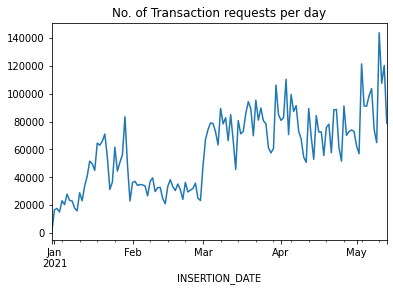

In [45]:
df1['TOTAL_AMOUNT'].resample('1D').count()
.plot(title="No. of Transaction requests per day")

<AxesSubplot:title={'center':'No. of Succcessful Transactions Per day'}, xlabel='INSERTION_DATE'>

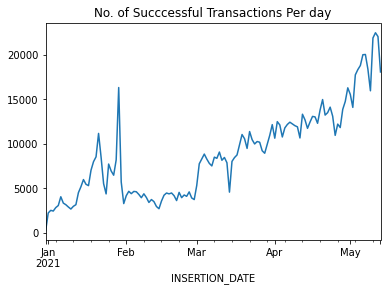

In [46]:
succesful_txns['TOTAL_AMOUNT'].resample('1D').count()
.plot(title='No. of Succcessful Transactions Per day')

<AxesSubplot:title={'center':'Succcessful Transaction Plot'}, xlabel='INSERTION_DATE'>

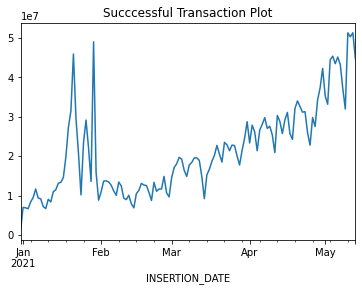

In [47]:
succesful_txns['TOTAL_AMOUNT'].resample('1D').sum()
.plot(title='Succcessful Transaction Plot')

<AxesSubplot:title={'center':'Daily Profits'}, xlabel='INSERTION_DATE'>

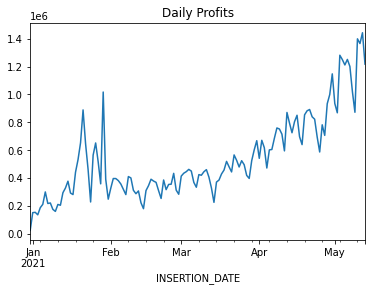

In [48]:
succesful_txns['PG_TDR_SC'].resample('1D').sum()
.plot(title='Daily Profits')

## Daily Sales Amount per merchant

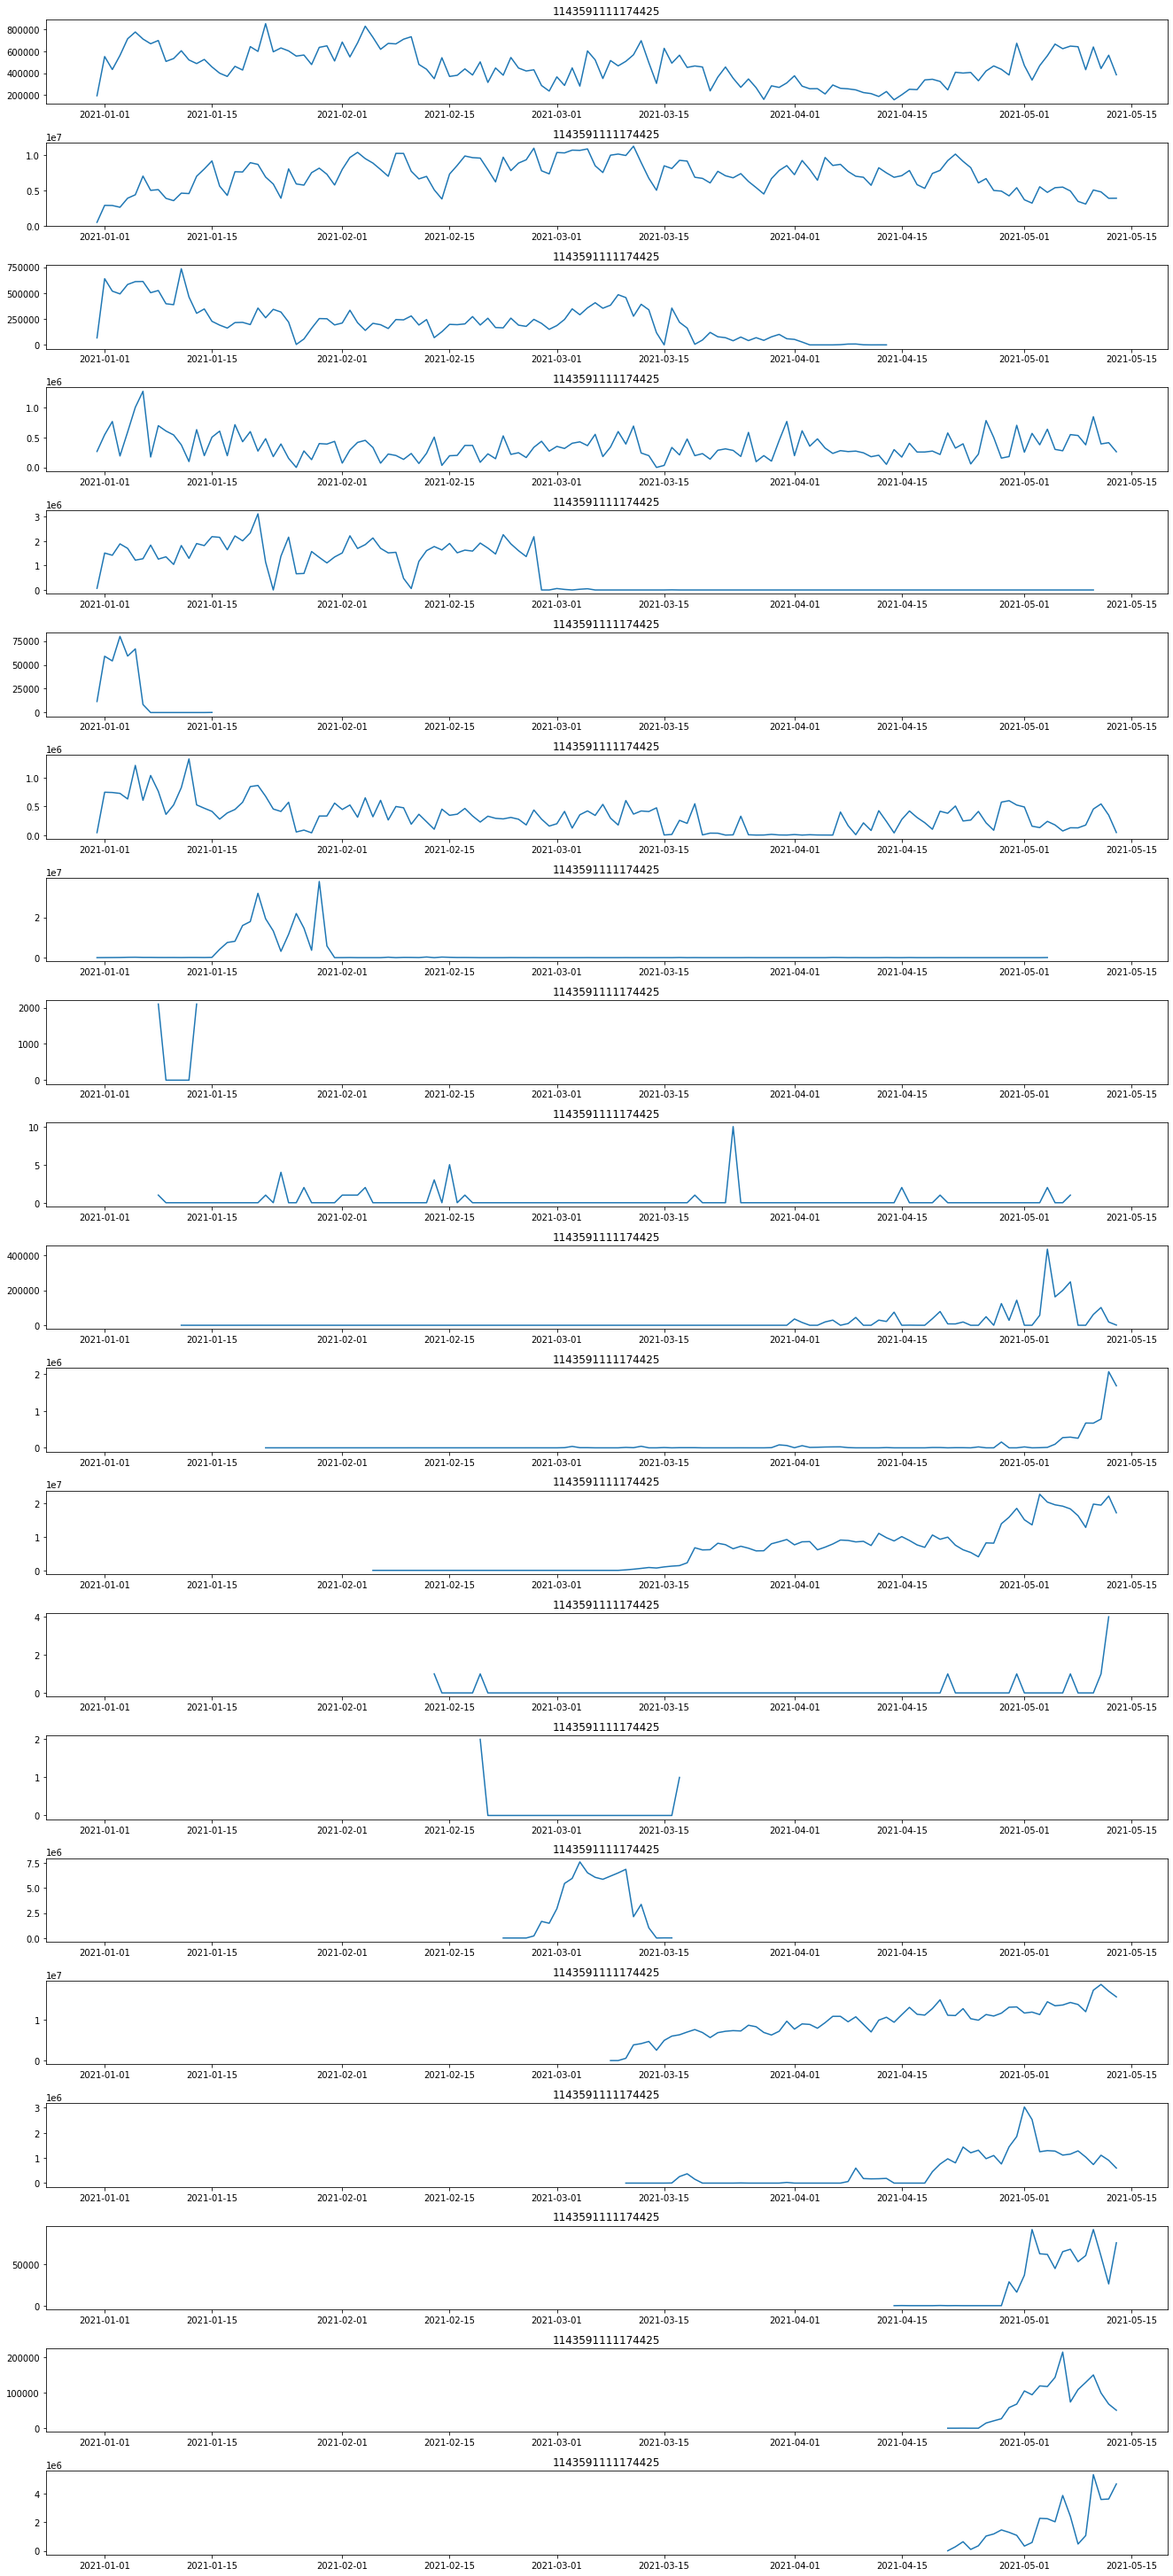

In [248]:
payids = succesful_txns['PAY_ID'].unique()
columns = 1
rows = math.ceil(len(payids)/columns)
fig,ax = plt.subplots(rows,columns,sharex=True,)
ax = ax.flatten()
for i in range(len(payids)):
    data = succesful_txns[succesful_txns['PAY_ID'] \
                          == payids[i]]['TOTAL_AMOUNT'].resample('1D').sum()
    ax[i].plot(data.index, data)
    ax[i].set_title(payid)
    ax[i].xaxis.set_tick_params(labelbottom=True)
fig.set_size_inches(18.5, 40.5)
fig.tight_layout() 


# Analysis of Daily Transaction Requests

I choose to analyse the Daily Transaction Requests since they represent the number of requests the application servers will need to process and can help allocate resources accordingly.

Lambda Value: 0.6837580203807049


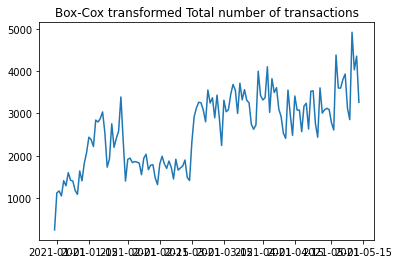

In [249]:
transformed, lmbd = boxcox(df1['TOTAL_AMOUNT'].resample('1D').count()+1e-6)
transformed = pd.DataFrame(data=transformed, index=df1['TOTAL_AMOUNT']
                           .resample('1D').count().index)
plt.plot(transformed)
plt.title("Box-Cox transformed Total number of transactions")
print('Lambda Value:',lmbd)

ADF Statistic: -6.798281
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


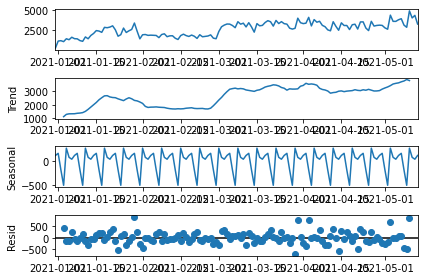

In [250]:
decomposition = seasonal_decompose(transformed)
decomposition.plot()
residuals = decomposition.resid
residuals = residuals[~np.isnan(residuals)]
result=adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

It is obvious from looking at the data that the time series is non-stationary. This can be attributed to the constant of onboarding of high frequency merchant in an effort to grow business. Further, we can also observe seasonality in the data. This is explainaible since the number of people online shopping increases during the weekend as compared to the weekdays. We confirm the seasonality duration by performing ADF test on the residuals which confirm that the residuals are white noise.

There are also outliers in the data around Jan 26/2021. This is a national holiday in India during which a lot of merchants have special offers thus we can observe a spike in the total number of transactions.

The lambda value also suggests that the seasonal variation for the given data is not stationary. Thus we apply box-cox transformation on the data to make seasonal variation stationary.

# Analysis of Daily Profits

I also choose to perform extended analysis on the daily profits collected by the Payment Gateway since it directly empowers the decision makers to see the progress and predict future growth. 

Lambda Value: 0.2902697399118416


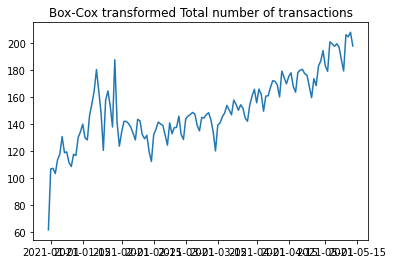

In [251]:
transformed, lmbd = boxcox(succesful_txns['PG_TDR_SC']
                           .resample('1D').sum()+1e-6)
transformed = pd.DataFrame(data=transformed, 
                           index=succesful_txns['PG_TDR_SC']
                           .resample('1D').sum().index)
plt.plot(transformed)
plt.title("Box-Cox transformed Total number of transactions")
print('Lambda Value:',lmbd)

ADF Statistic: -7.994487
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


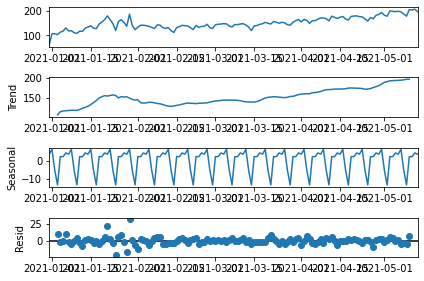

In [157]:
decomposition = seasonal_decompose(transformed)
decomposition.plot()
residuals = decomposition.resid
residuals = residuals[~np.isnan(residuals)]
result=adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

It is obvious from looking at the data that this time series is also non-stationary. The same argument holds for this time series as it did for the total number of transactions time series as presented above. Thus, this time 
series is also non-stationary, has a seasonal period of 7 days and the seasonal variations are not stationary.


This also suggests a consumer pattern, even though the number of transactions are increasing, each user on average is spending the same amount. This can be further confirmed by the plot below, which plot the sales_amount/sales_count for each day. There is a sharp decline around beginning of March. This according to my opinion can be attributed to the end of the tax year in India which happens in March and when a lot of taxes are due by people since they limit their spending.

<AxesSubplot:xlabel='INSERTION_DATE'>

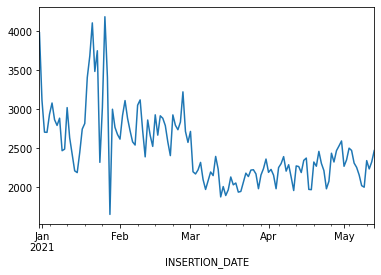

In [253]:
(succesful_txns['TOTAL_AMOUNT'].resample('1D').sum()/succesful_txns['TOTAL_AMOUNT'].resample('1D').count()).plot()

# Predictions on the Daily Profits Data

## KPSS Test

We use the KPSS test to find the degree of differencing which would make the data stationary.

KPSS Test passes at diff n = 1


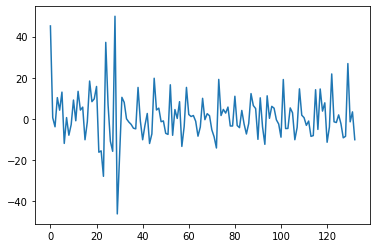

In [254]:
i = 0 
while True:
    result = kpss(np.diff(np.array(transformed).reshape(-1),n=i))
    if all(map(lambda x: x> result[0], result[3].values())):
        break
    i+=1
print("KPSS Test passes at diff n =", i)
plt.plot(np.diff(np.array(transformed).reshape(-1),n=i))

## ACF PACF Plots

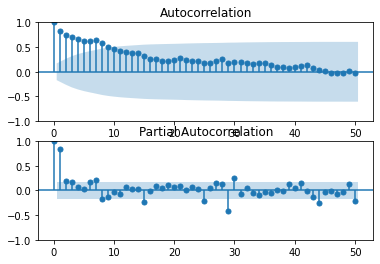

In [255]:
plt.figure()
plt.subplot(211)
plot_acf(transformed, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(transformed, lags=50, ax=plt.gca())
plt.show()

## ARIMA Model
Observing the above PACF and ACF plot, we try to estimate an ARIMA model, and then use grid search to find an optimal ARIMA model.

In [256]:
X = transformed.values
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f'% rmse)

RMSE: 8.069


In [163]:
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse
def evaluate_models(dataset, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f'% (order,rmse))
        except Exception as e:
          print(e)
          continue
  print('Best ARIMA%s RMSE=%.3f'% (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)
warnings.filterwarnings("ignore")
evaluate_models(transformed.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=30.508
ARIMA(0, 0, 1) RMSE=19.653
ARIMA(0, 0, 2) RMSE=14.938
ARIMA(0, 0, 3) RMSE=14.444
ARIMA(0, 0, 4) RMSE=11.505
ARIMA(0, 0, 5) RMSE=9.969
ARIMA(0, 1, 0) RMSE=8.676
ARIMA(0, 1, 1) RMSE=8.363
ARIMA(0, 1, 2) RMSE=8.069
ARIMA(0, 1, 3) RMSE=8.104
ARIMA(0, 1, 4) RMSE=8.069
ARIMA(0, 1, 5) RMSE=8.109
ARIMA(1, 0, 0) RMSE=9.627
ARIMA(1, 0, 1) RMSE=8.910
ARIMA(1, 0, 2) RMSE=8.466
ARIMA(1, 0, 3) RMSE=8.505
ARIMA(1, 0, 4) RMSE=8.460
ARIMA(1, 0, 5) RMSE=8.685
ARIMA(1, 1, 0) RMSE=8.509
ARIMA(1, 1, 1) RMSE=8.120
ARIMA(1, 1, 2) RMSE=8.088
ARIMA(1, 1, 3) RMSE=8.284
ARIMA(1, 1, 4) RMSE=8.100
ARIMA(1, 1, 5) RMSE=8.123
ARIMA(2, 0, 0) RMSE=9.311
ARIMA(2, 0, 1) RMSE=8.532
ARIMA(2, 0, 2) RMSE=8.489
ARIMA(2, 0, 3) RMSE=8.677
ARIMA(2, 0, 4) RMSE=8.713
ARIMA(2, 0, 5) RMSE=8.754
ARIMA(2, 1, 0) RMSE=8.318
ARIMA(2, 1, 1) RMSE=8.108
ARIMA(2, 1, 2) RMSE=8.163
ARIMA(2, 1, 3) RMSE=7.971
ARIMA(2, 1, 4) RMSE=7.843
ARIMA(2, 1, 5) RMSE=7.875
ARIMA(3, 0, 0) RMSE=8.853
ARIMA(3, 0, 1) RMSE=8.515
ARIMA(3

In [257]:
train_size = int(len(transformed) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error


Error: 7.811719320670983


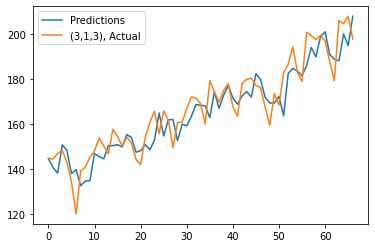

In [258]:
plt.plot(predictions,label="Predictions")
plt.plot(test,label="(3,1,3), Actual")
plt.legend()
print("Error:",np.sqrt(mean_squared_error(predictions,test)))

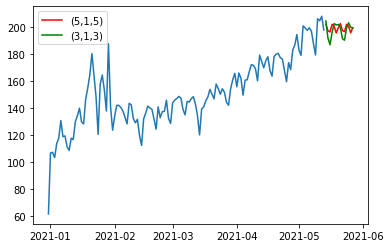

In [259]:
model = ARIMA(transformed, order=(3,1,3))
model_fit = model.fit()
yhat = model_fit.forecast(14)
plt.plot(transformed)
plt.plot([transformed.index[-1]+timedelta(days=i+1) for i in range(14)]
         ,yhat,'r',label="(5,1,5)")
model = ARIMA(transformed, order=(5,1,5))
model_fit = model.fit()
yhat = model_fit.forecast(14)
plt.plot([transformed.index[-1]+timedelta(days=i+1) for i in range(14)]
         ,yhat,'g',label="(3,1,3)")
plt.legend()

The ARIMA models obtained from the above analysis to do not give multi-step forecasts as can be observed from the plot above. Additionally, the grid search always selects more complex models as the search space is increase from 3,3 to 5,5. This suggests that the ARIMA models are not able to fully fit onto the given data

## RNN Based Model

We now choose to perform forecasting using RNN models since they can model arbitrary relationships and are prone to outliers. We choose the step size as 14 so as to encompass 2 weeks of data and choose the number hidden units arbitrarily. We also set the number of epochs to 300 since that gave us good results without significant overfitting.

In [260]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [261]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
  # find the end of this pattern
    end_ix = i + n_steps
  # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [269]:
n_steps = 14
X, y = split_sequence(np.array(transformed), n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=250,verbose=0)

RMSE: 4.9049325528992425


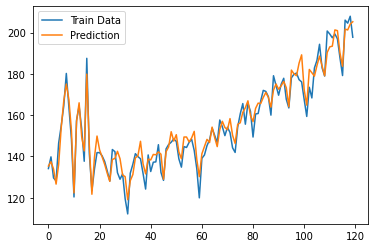

In [270]:
x_input,y = split_sequence(np.array(transformed), n_steps)
model.predict(x_input)
plt.plot(y,label="Train Data")
plt.plot(model.predict(x_input),label="Prediction")
plt.legend()
print("RMSE:",np.sqrt(mean_squared_error(y,model.predict(x_input))))


In [271]:
future_steps = 30
x = np.array(transformed[-n_steps:]).flatten()
predictions = []
for i in range(future_steps):
    pred = model.predict(x.reshape((1, n_steps, n_features)))[0][0]
    x = x.tolist()
    x.append(pred)
    x = np.array(x)[1:]
    predictions.append(pred)

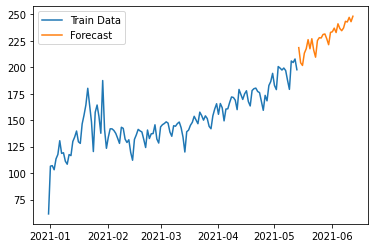

In [272]:
plt.plot(transformed,label="Train Data")
plt.plot([transformed.index[-1]+timedelta(days=i+1) 
          for i in range(future_steps)],predictions,label="Forecast")
plt.legend()

As we can see, we get significantly better results by using RNN models. However, we suspect there might be sime overfitting of data which warrants further analysis.

# Final Conclusion

We observe that we get good results with ARIMA model but the model parameters of `p` and `q` are very high and thus the model are more complex than required. We also train a RNN model which performs significantly better as compared to ARIMA models but may be prone to overfitting. Thus, in the current state, we go ahead with the RNN model.

# Next Steps

We hypothesise that we can achieve better results by using bottoms up forecasting, where we fit different model for each merchant and then aggregate those predictions. We will analyse and present this approach in the final submission along with the dashboard that needs to be presented.

In [5]:
df1.to_csv('/Volumes/GoogleDrive/My Drive/cashlesso data/pruned_data/txns2.csv')